# Install non-standard libraries

In [1]:
# ! pip install opencv-python # ! sign tells the system that it is a shell command but not python one
# ! pip install albumentations
# ! pip install tesseract # OCR backed up by Goggle Engine
# ! pip install pytesseract # python wrapper for implementation of tesseract

# Import Libraries

In [103]:
import skimage # sibling of sklearn but for Image PRocessing
import numpy as np # we all know
import pandas as pd # evolved numpy
import matplotlib.pyplot as plt # This one is a true creator
import warnings # No one liked warnings
from keras.datasets import cifar10 # image data
import random # to perform random tasks
import cv2
# import albumentations as alb # it is a fun and knowledge library
from PIL import Image, ImageFilter # Image is you know, image and filters
import requests # request something fom the internet, it ALWAYS returns something 
from io import BytesIO # Read some file as byte file
from skimage import feature #problem with sklearn imports so if error comes, export modules explicitly
import pytesseract
from IPython import display # interesting function to show images without matplotlib

In [3]:
warnings.filterwarnings('ignore') # ignore all warning because "I don't care what they say, I gotta learn"

# Basic Operations

## Reading and Plotting Image

(300, 451, 3)


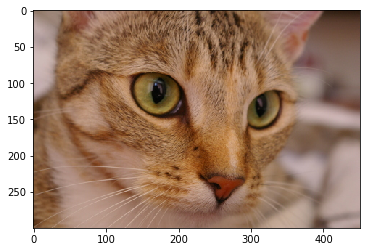

In [4]:
chelsea = skimage.data.chelsea() # data is given here already
print(chelsea.shape)
plt.imshow(chelsea)
plt.show()

## Flip and Rotate

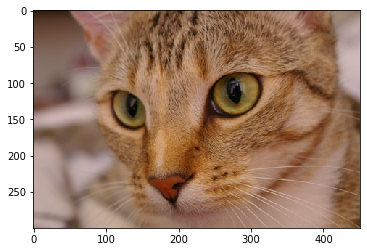

In [5]:
plt.imshow(np.fliplr(chelsea))

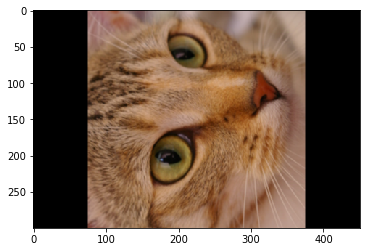

In [6]:
plt.imshow(skimage.transform.rotate(chelsea,90))

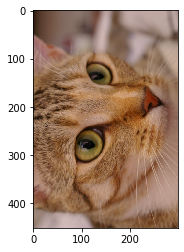

In [7]:
plt.imshow(np.rot90(chelsea))

## Masking

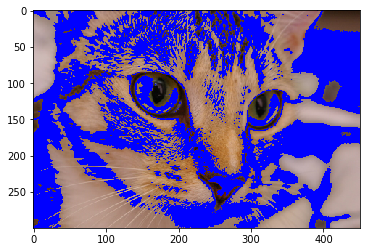

In [8]:
blue_chelsea = chelsea.copy()
mask = (blue_chelsea[:,:,0]>103) & (blue_chelsea[:,:,0]<153)  # get random pixels based on a condition
blue_chelsea[mask] = [0,0,255] # turn the mask as blue
plt.imshow(blue_chelsea)

## Color scheme Conversion

### RGB to Grayscale
3 channels merged into one. 0-255 range becomes 0 or 1

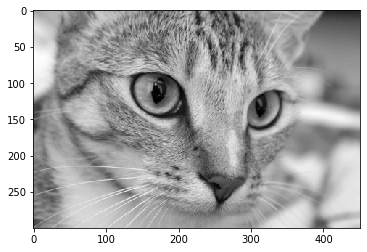

In [9]:
plt.imshow(skimage.color.rgb2gray(chelsea),cmap='gray') # RGB to grayscale

### Invert colors
High intensity pixels are interchanges with low intensity pixels

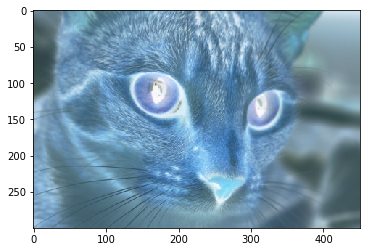

In [10]:
plt.imshow(skimage.util.invert(chelsea)) # inverted colors

### RGB to BGR

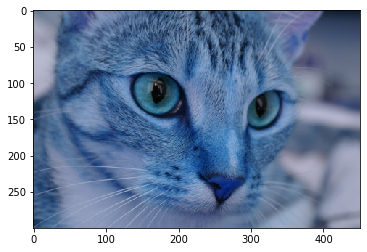

In [11]:
BGR_chelsea = chelsea[:,:,::-1]
plt.imshow(BGR_chelsea) # RGB to BGR

## Crop

In [12]:
def crop_center(img,y,x):
    h,w,c = img.shape
    start_w = w//2 - (x//2)
    start_h = h//2 - (y//2)
    return img[start_h:start_h+y,start_w:start_w+w]

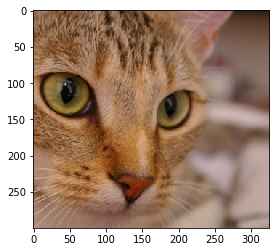

In [13]:
plt.imshow(crop_center(chelsea,300,200))

# Pooling
A lying or standing cat is still a cat due to its features not the location of features. Convolution layers sometimes give importance to the location so pooling tries to minimize that effect.
[Pooling Layers](https://iq.opengenus.org/pooling-layers/)

In [14]:
gray = skimage.color.rgb2gray(chelsea)
resized = skimage.transform.resize(gray,(300,448)) # original is 300,451

In [15]:
kernal = (4,4) # or block
blocked = skimage.util.view_as_blocks(resized,kernal)
# w,h should be completely divided by kernal size
blocked.shape

(75, 112, 4, 4)

In [16]:
# reshape the image while preserving the Width and Height OR simply merge color and patches channels
reshaped = blocked.reshape(blocked.shape[0],blocked.shape[1],-1)
reshaped.shape

(75, 112, 16)

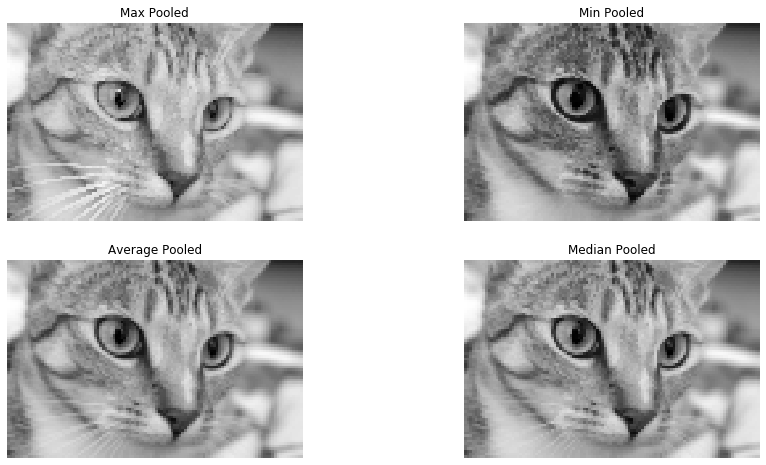

In [17]:
# MAx pooling
max_pooled = np.max(reshaped,axis=2)
avg_pooled = np.mean(reshaped,axis=2)
min_pooled = np.min(reshaped,axis=2)
med_pooled = np.median(reshaped,axis=2)

f,ax = plt.subplots(2,2,figsize=(15,8))
ax = ax.ravel()

ax[0].imshow(max_pooled,cmap='gray')
ax[0].set_title('Max Pooled')
ax[0].axis('off')

ax[1].imshow(min_pooled,cmap='gray')
ax[1].set_title('Min Pooled')
ax[1].axis('off')

ax[2].imshow(avg_pooled,cmap='gray')
ax[2].set_title('Average Pooled')
ax[2].axis('off')

ax[3].imshow(med_pooled,cmap='gray')
ax[3].set_title('Median Pooled')
ax[3].axis('off')


plt.show()

# ZCA Whitening and Normalization

Shape of images array is: (1000, 32, 32, 3)


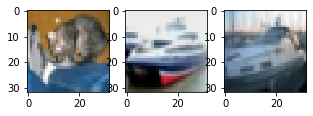

In [18]:
(_,_),(images,_) = cifar10.load_data() 
# (X_train,y_tain),(x_test,y_test) but we need less in quantity so we just imported x_test

images = images[:1000] # just use the first 1000 images for demo

print(f'Shape of images array is: {images.shape}')

f,ax = plt.subplots(1,3,figsize=(5,5))
ax = ax.ravel()
for i in range(3):
    ax[i].imshow(images[i])
plt.show()

In [19]:
images = images.reshape(-1,(32*32*3)) # -1 means it choses the best suitable i.e 1000 in our case
print(f' new shape of images is {images.shape}')

 new shape of images is (1000, 3072)


## ZCA Whitening
ZCA decorrelates the Image Features or transforms the image in such a way that makes the covariance matrix of the image as identity matrix

In [20]:
 # find the covariance matrix. i.e how much two variables change together
cov_mat = np.cov(images)

# singular value decomposition SVD (dimensionality reduction technique to find  hidden latent features)
# a plastic bag, douchebag and a weapon can have a latent feature that they are all from USA ;)
U,S,V = np.linalg.svd(cov_mat)

# dot product to get the principal components
epsilon = 0.000001 # avoid division by zero
w = np.diag(1.0/np.sqrt(S+epsilon)) # diagonal matrix
x = np.dot(w,U.T) # U transpose     
components = np.dot(U,x)

# calculate zca by using dot products of the principal components by images 
zca_images = np.dot(components,images)
zca_images.shape

(1000, 3072)

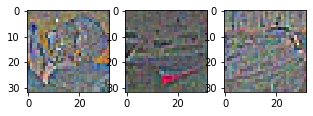

In [21]:
f,ax = plt.subplots(1,3,figsize=(5,5))
ax = ax.ravel()
for i in range(3):
    # clip the images in some range for matplotlib else it'll throw error
    img = zca_images[i].reshape((32,32,3))
    min_,max_ = img.min(), img.max()
    ax[i].imshow((img-min_)/(max_-min_))  # clipping
plt.show()

## Normalization
Normalization makes the pixel centered of image around mean 0 by subtracting the pixels of an image from the mean of whole **batch** of images and dividing by the standard deviation of the **batch**

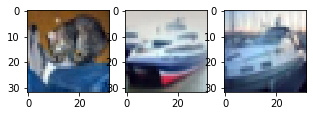

In [22]:
images = images - images.mean(axis=0) # subtract the mean of whole 10000 images from each image
images = images/images.std(axis=0) # divide by the standard deviation

f,ax = plt.subplots(1,3,figsize=(5,5))
ax = ax.ravel()
for i in range(3):
    # clip the images in some range for matplotlib else it'll throw error
    img = images[i].reshape((32,32,3))
    min_,max_ = img.min(), img.max()
    ax[i].imshow((img-min_)/(max_-min_))  # clipping
plt.show()

# De-Noising
To save time here, let us just resize the image then we will add Gaussian Noise. 

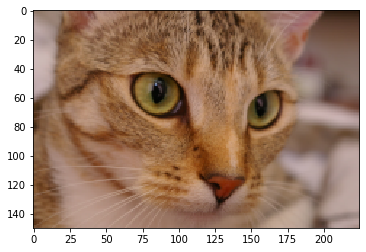

In [23]:
resized = skimage.transform.resize(chelsea,(chelsea.shape[0]//2,chelsea.shape[1]//2)) 
# resize to half preserving the aspect ratio
plt.imshow(resized)

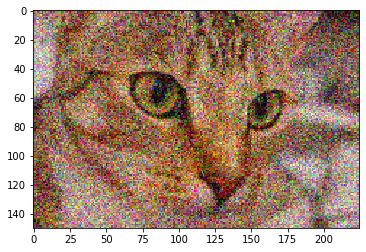

In [24]:
# add Gaussian Noise
sigma = 0.17 # defines the type/shape of distribution high sigma = high noise
noised = skimage.util.random_noise(resized,mode='gaussian', var=sigma**2)
plt.imshow(noised)

In [25]:
# if our image has Gaussian noise, this can detect and tell us the sigma. Our result is close to our sigma

skimage.restoration.estimate_sigma(noised,multichannel=True,average_sigmas=True)
# we want to calculate the noise for each of the RGB channel (multichannel=True) and want avg. for all

0.16119851361538728

### TV Chambolle

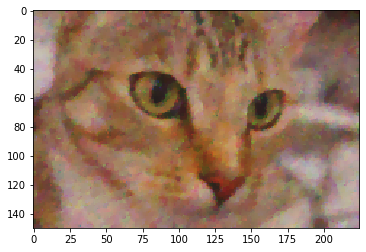

In [26]:
# it makes the 'normalization' value close to the normal image by using 100 iteration by default

tv_cham = skimage.restoration.denoise_tv_chambolle(noised,multichannel=True,weight=0.12)
plt.imshow(tv_cham)
# output depends on the weight. High value of weight makes the image blurry and far from original

### Bilateral

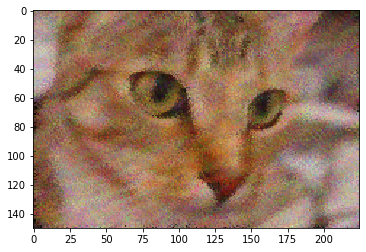

In [27]:
# this preserves the edges and works on closeness of pixels (spatial closeness) and 
# how two pixels are similar in their color channels (radiometric similarity)

bilat = skimage.restoration.denoise_bilateral(noised,multichannel=True,sigma_color=0.09,sigma_spatial=1.3)
plt.imshow(bilat)
# both the sigma as parameters are standard deviations for spatial closeness and radiometric similarity
# try to use high sigma_spatial. It'll take lot of time and the black portion at the bottom will increase

### Wavelet

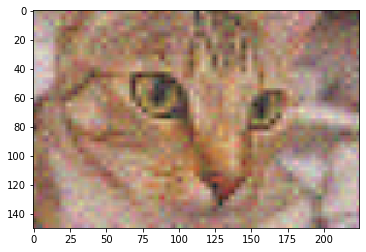

In [42]:
# this works on the wavelength representation of image and follows the luminosity (Y) and chroma components
# (Cb,Cr) so it is YCbCr instead of RGB format

img = skimage.restoration.denoise_wavelet(noised,multichannel=True,wavelet='db2',method='VisuShrink')

min_,max_ = img.min(), img.max()
plt.imshow((img-min_)/(max_-min_)) # clipping

# try to read the documentation about the parameters. These vary from image to image

### Non Local Means

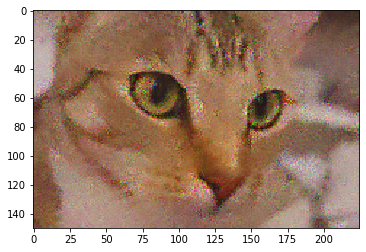

In [29]:
# it takes a mean of all pixels, weighted by how similar these pixels are to the target pixel. 
# This results in greater post-filtering clarity than local means
nl_mean = skimage.restoration.denoise_nl_means(noised,multichannel=True,patch_size=6,patch_distance=13)
plt.imshow(nl_mean)

In [30]:
def get_image_from_url(source):
    response = requests.get(source)
    img = Image.open(BytesIO(response.content))
    return np.array(img)

# Feature Detection
Feature and area detection are two different things. Area or segement or blobs are the portion of image we are interested in and features are significant features like what is the brightness, txture, color for that area.3 algorithms are used for this purpose.
1. SIFT
2. DAISY
3. Histogram

## SIFT
Most popular and mostly used. Finds the keypoints from a corpus of images and try to match for new image.

<font color='red'><b>NOTE</b>: SIFT code can produce errors and might not work with your version of  `opencv` because this algorithm has a patent and the creators have removed it from the opencv package >3.6. I have version 3.4. If you want to use it, you need to build the code from github repo from `opencv-contrib-python`</font>

In [31]:
# open Cv has all the workings in BGR format
dog1 = cv2.imread('single.jpeg')
dog2 = cv2.imread('duo.jpeg')

gray1 = cv2.cvtColor(dog1,cv2.COLOR_BGR2GRAY) # working with grayscale is fast
gray2 = cv2.cvtColor(dog2,cv2.COLOR_BGR2GRAY)

In [32]:
sift_obj = cv2.xfeatures2d.SIFT_create() # instantiate the sift objct
kp1 = sift_obj.detect(gray1,None)
kp2 = sift_obj.detect(gray2,None) # detect the list of keypoints where mask is none

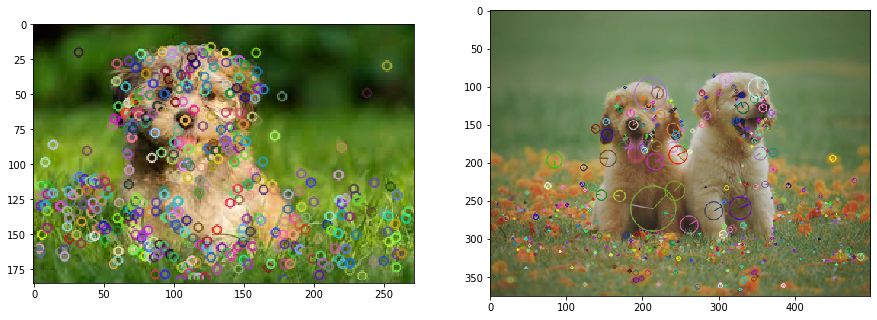

In [33]:
dog1_kp = cv2.drawKeypoints(dog1,kp1,outImage=None)
dog2_kp = cv2.drawKeypoints(dog2,kp2,outImage=None,flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
# second one has the keypoints with different sizes to tell which region is used to form the keypoint
# it also has gradient or direction of keypoint as line inside circle

f,ax = plt.subplots(1,2,figsize=(15,7))
ax[0].imshow(cv2.cvtColor(dog1_kp,cv2.COLOR_BGR2RGB),) # we are used to see the RGB format
ax[1].imshow(cv2.cvtColor(dog2_kp,cv2.COLOR_BGR2RGB),)

### Find Descriptor from the Keypoints
Descriptors and scale are associatd with every keypoint. Keypoints are area of interest but descroptiors are special features which describes texture, color etc about the keypoint

In [34]:
kp1,descr1 = sift_obj.compute(gray1,kp1)
print(f'Descriptors is of type {type(descr1)} and has shape {descr1.shape}') # array of numbers

Descriptors is of type <class 'numpy.ndarray'> and has shape (478, 128)


In [35]:
dog3 = cv2.imread('triplet.jpeg')
gray3 = cv2.cvtColor(dog3,cv2.COLOR_BGR2GRAY)
kp3,descr3 = sift_obj.detectAndCompute(gray3,None) # directly find and compute features

### Match Features across Images

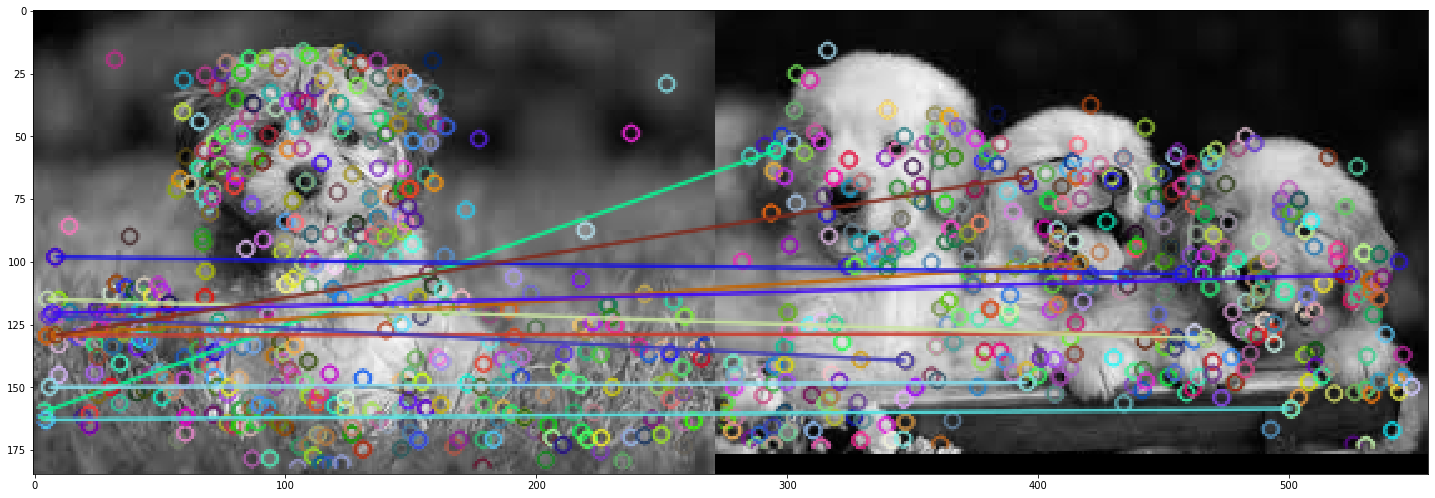

In [36]:
# Brute Force Matcher
bf_matcher = cv2.BFMatcher(cv2.NORM_L2,crossCheck=False) # match the features using L2 distance
matches = bf_matcher.match(descr1,descr3)

matched_image = cv2.drawMatches(gray1,kp1,gray3,kp3,matches[:10],gray1.copy(),flags=0)
# show the first 10 matches of 2 images keeping the first image as reference 

plt.figure(figsize=(25,20))
plt.imshow(matched_image)

## DAISY
Same as SIFT but faster and uses dimentionality reduction such as PCA

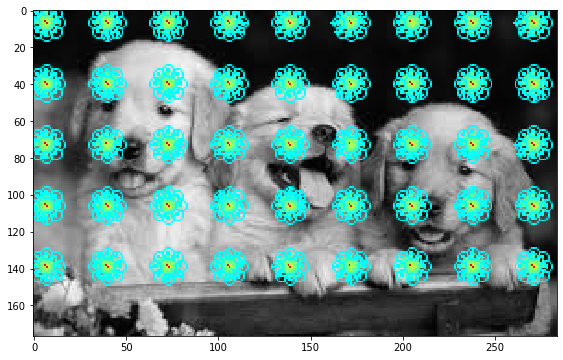

In [37]:
descs, desc_img = feature.daisy(gray3,step=33,radius=7,visualize=True)
# use circular Gaussian Window with radius 2 to smooth the image and calculate the histograms of gradients
# use the distance of 30 between two sampling points
# number of keypoints change based on the radius and step

fig = plt.figure(figsize=(12,6))
plt.imshow(desc_img)

### HOG: Histogram of Oriented Gradients
Used for object detection and is based on idea that different objects have dfferent directions for pixel intensities. A boundry seperating the object and the background can be identified by the distribution of same type of continuous intensities and specially the direction.

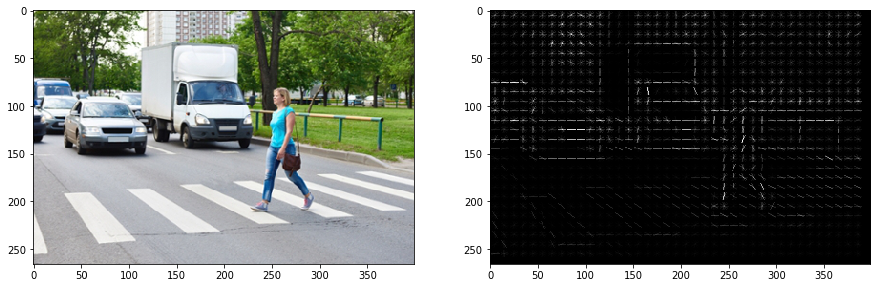

In [93]:
pedestrian = skimage.io.imread('single pad.jpg')

feature_descriptors, feat_image = feature.hog(pedestrian,visualize=True,multichannel=True,
                                             pixels_per_cell=(10,10),cells_per_block=(4,4),
                                              block_norm='L2-Hys')

#feat_image = skimage.exposure.rescale_intensity(feat_image,in_range=(0,50))
# normalize the pixel intensity ranges 

f,ax = plt.subplots(1,2,figsize=(15,6))
ax[0].imshow(pedestrian)
ax[1].imshow(feat_image,cmap='gray')
plt.show()

**Try out different parameters specially `pixels_per_cell` to get more granular or more coarse features**

# OCR: Optical Character Recognition
Extracting Text from Images

In [143]:
img = Image.open('quote.png')
print(f'Our Image is of {img.format} format with dimensions {img.size} and belongs to {type(img)}') 
# it is not a numpy array

Our Image is of PNG format with dimensions (186, 271) and belongs to <class 'PIL.PngImagePlugin.PngImageFile'>


In [144]:
print(pytesseract.image_to_string('quote.png',lang='eng')) # you can directly pass the img object

I love the
attention
but I don't
like too
much of it.

- Eminem


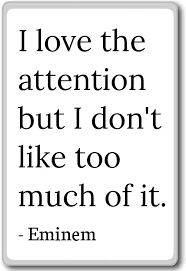

In [145]:
display.Image('quote.png',width=img.size[0],height=img.size[1])

It'll work to an extant of noise too.

<font color='green'>Fun Thing:</font> *Try to flip the image to see how tesseract sees the image.*

# Continue.....
Thank you all. I'll be writing another series in working with images which will include object detection, dimensionality reduction, autoencoders and much more. I'll be putting the link and you can see the same name as Part:2.